# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


## Data Preparation

In [ ]:
# Beispiel Daten laden
data = pd.read_csv('./../Data/preprocessed_df.csv') # Pfad zu Ihren Daten

print(data.head())

# Daten skalieren
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Dimension der Eingabedaten
input_dim = data_scaled.shape[1]

## GAN Definition

In [ ]:
def build_generator(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', kernel_initializer='glorot_normal'),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(momentum=0.8),
        layers.Dense(input_dim, activation='tanh')
    ])
    return model

## Discriminator Definition

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

## Build Model

In [ ]:
generator = build_generator(input_dim)
discriminator = build_discriminator()

# Kompilieren des Discriminators
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Kombiniertes Modell (Generator und Discriminator)
discriminator.trainable=False
gan_input = tf.keras.Input(shape=(input_dim,))
x = generator(gan_input)
gan_output= discriminator(x)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

## Training

In [ ]:
epochs = 100
batch_size = 32

X_train = data_scaled

d_losses, g_losses = [], []

for epoch in range(epochs):
    # Schritt 1: Trainiere den Diskriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_data = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, input_dim))
    generated_data = generator.predict(noise)

    real_y = np.ones((batch_size, 1))
    fake_y = np.zeros((batch_size, 1))

    x_combined_batch = np.concatenate((real_data, generated_data))
    y_combined_batch = np.concatenate((real_y, fake_y))
    
    d_loss = discriminator.train_on_batch(x_combined_batch, y_combined_batch)
    d_losses.append(d_loss)  # Sammle Diskriminator-Verlust

    # Schritt 2: Trainiere den Generator
    noise = np.random.normal(0, 1, (batch_size, input_dim))
    valid_y = np.ones((batch_size, 1))

    g_loss = gan.train_on_batch(noise, valid_y)
    g_losses.append(g_loss[0])  # Sammle Generator-Verlust

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

# Nach dem Training
print("GAN training is complete.")
print("Generator's weights:")
generator.summary()
print("Discriminator's weights:")
discriminator.summary()



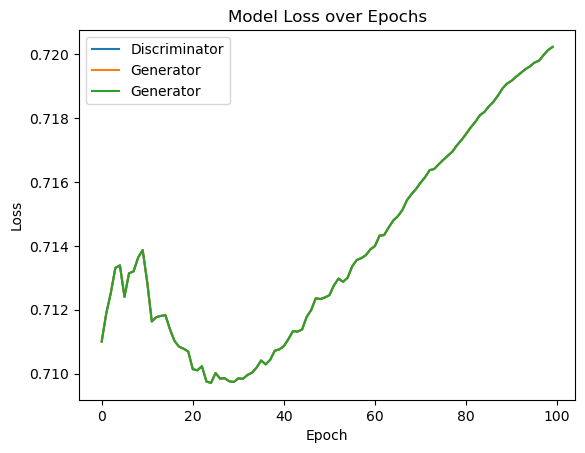

In [18]:
# Verlustkurven plotten
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Evaluation

In [19]:
def generate_new_data(generator, input_dim, num_samples=10):
    """
    Generiert neue Daten mit dem trainierten Generator des GANs.
    
    :param generator: Das trainierte Generator-Modell des GANs.
    :param num_samples: Die Anzahl der Datensätze, die generiert werden sollen.
    :param input_dim: Die Dimension des latenten Raumes.
    :return: Ein Array generierter Daten.
    """
    # Erzeugen der Zufallseingaben (Rauschen) für den Generator
    noise = np.random.normal(0, 1, (num_samples, input_dim))
    
    # Verwende den Generator, um aus dem Rauschen neue Daten zu erzeugen
    generated_data = generator.predict(noise)

    # Skaliere die Daten zurück
    generated_data = scaler.inverse_transform(generated_data)
    
    generated_data = pd.DataFrame(generated_data, columns=data.columns)
    
    return generated_data


In [20]:
num_samples_to_generate = 5  
generated_data = generate_new_data(generator, num_samples=num_samples_to_generate, input_dim=input_dim)

print("Generated Data:")
print(generated_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Generated Data:
   participant_id   test_id  test_duration     mental    physical   temporal  \
0      -43.974396  3.982081    5250.153320  99.576218  -20.876423  12.880302   
1      -37.702297 -1.990880    7104.748535 -89.615242  -76.765388  98.072044   
2      -31.074808 -1.982655   -6387.305664  99.667831   97.994263  85.556007   
3      -38.096512 -1.995712   -7227.163574  99.977821   99.999802  96.287888   
4      -31.638695 -1.999604   -7227.165039  99.994865  100.000000  99.916595   

   performance     effort  frustration       mean  mean_pupil_diameter  \
0    94.918304  99.983490    99.987602  83.065651            47.793964   
1   -92.131676 -52.310108   -87.347160 -73.738808            50.032768   
2    94.617653  96.129433   -81.500412  83.905350             3.551703   
3    94.128548  99.893921   -89.947617  83.573303             1.169857   
4    94.959663  99.970001   -89.690948  84.146004             1.169565   

   median_pupil_diam